In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/engg680_2024_fall/G14_Final_project/

/content/drive/MyDrive/engg680_2024_fall/G14_Final_project


In [3]:
!ls

cleaned_traffic_data.xlsx  final_merged_traffic_data.xlsx
engg680_2024_fall	   G14_Traffic_lights_project.ipynb


In [ ]:
# Step 1.1: Import necessary libraries
import pandas as pd

# Step 1.2: Define the file path
file_path = '/content/drive/MyDrive/engg680_2024_fall/Final_project/final_merged_traffic_data.xlsx'

# Step 1.3: Load the dataset into a pandas DataFrame
df = pd.read_excel(file_path)

# Step 1.4: Display the first few rows to understand the structure
print("First few rows of the dataset:")
print(df.head())

# Step 1.5: Check the columns and their data types
print("\nColumn information:")
print(df.info())

# Step 1.6: Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Step 1.7: Display basic statistics for numerical columns
print("\nBasic statistics for numerical columns:")
print(df.describe())

First few rows of the dataset:
  start_time  north_left  north_straight  north_right  north_truck  \
0      07:00          24               0            0            0   
1      07:15          38               0            0            1   
2      07:30          44               0            0            0   
3      07:45          44               0            0            3   
4      08:00          23               0            0            0   

   north_pedestrian  north_bike  south_left  south_straight  south_right  ...  \
0                 4           0           0               0            0  ...   
1                 2           0           0               0            0  ...   
2                 4           0           0               0            0  ...   
3                 4           0           0               0            0  ...   
4                 7           0           0               0            0  ...   

   east_truck  east_pedestrian  east_bike  west_left  west_st

In [ ]:
# Step 2.1: Convert 'date' and 'start_time' to a single 'timestamp' column
df['timestamp'] = pd.to_datetime(df['date'] + ' ' + df['start_time'])

# Step 2.2: Create a 'peak_hour' column
# Define peak hours (e.g., 07:00-09:00 and 16:00-18:00)
def is_peak_hour(timestamp):
    hour = timestamp.hour
    return 1 if (7 <= hour < 9 or 16 <= hour < 18) else 0

df['peak_hour'] = df['timestamp'].apply(is_peak_hour)

# Step 2.3: Simulate an 'emergency_vehicle' column
# Randomly assign emergency presence with 10% probability (1 = emergency, 0 = normal)
import numpy as np
np.random.seed(42)  # Ensure reproducibility
df['emergency_vehicle'] = np.random.choice([0, 1], size=len(df), p=[0.9, 0.1])

# Step 2.4: Review columns with all zero values
zero_columns = [col for col in df.columns if df[col].nunique() == 1 and df[col].unique()[0] == 0]
print(f"\nColumns with all zero values: {zero_columns}")

# Drop columns with all zero values (optional)
df = df.drop(columns=zero_columns)

# Step 2.5: Display the updated DataFrame
print("\nFirst few rows of the updated dataset:")
print(df.head())

# Save the cleaned dataset (optional)
cleaned_file_path = '/content/drive/MyDrive/engg680_2024_fall/Final_project/cleaned_traffic_data.xlsx'
df.to_excel(cleaned_file_path, index=False)
print(f"\nCleaned dataset saved to: {cleaned_file_path}")


Columns with all zero values: ['north_straight', 'south_left', 'south_straight', 'south_right', 'south_truck', 'east_left', 'east_straight', 'east_right', 'east_truck', 'west_right']

First few rows of the updated dataset:
  start_time  north_left  north_right  north_truck  north_pedestrian  \
0      07:00          24            0            0                 4   
1      07:15          38            0            1                 2   
2      07:30          44            0            0                 4   
3      07:45          44            0            3                 4   
4      08:00          23            0            0                 7   

   north_bike  south_pedestrian  south_bike  east_pedestrian  east_bike  \
0           0                 0           0                9          0   
1           0                 0           0               47          0   
2           0                 0           0               52          0   
3           0                 0           0

In [ ]:
# Step 3.1: Select relevant features and target variable
# Features include all columns related to traffic counts, pedestrians, bikes, and peak_hour
# Target variable will be 'emergency_vehicle'
features = df.drop(columns=['date', 'start_time', 'timestamp', 'emergency_vehicle'])
target = df['emergency_vehicle']

# Step 3.2: Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 3.3: Display shapes of the training and testing sets
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

Training features shape: (384, 15)
Testing features shape: (96, 15)
Training target shape: (384,)
Testing target shape: (96,)


In [ ]:
!pip install -U imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.3 MB/s eta 0:00:00


Model Accuracy After Resampling: 0.61

Classification Report After Resampling:
              precision    recall  f1-score   support

           0       0.91      0.61      0.73        83
           1       0.20      0.62      0.30        13

    accuracy                           0.61        96
   macro avg       0.56      0.61      0.52        96
weighted avg       0.81      0.61      0.68        96


Confusion Matrix After Resampling:
[[51 32]
 [ 5  8]]


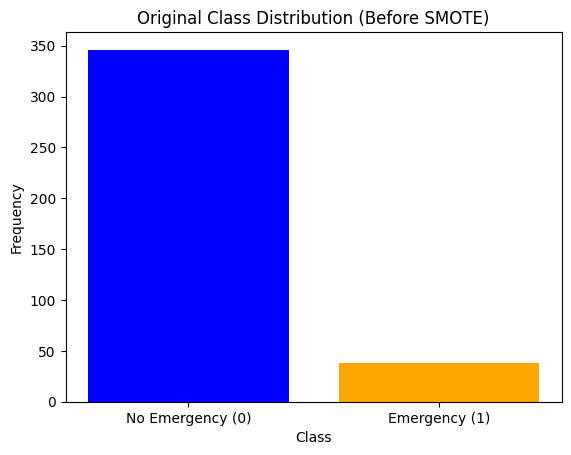

In [ ]:
# Step 4.1: Address class imbalance using SMOTE (Synthetic Minority Oversampling Technique)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Step 4.2: Scale the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Step 4.3: Train Logistic Regression with more iterations
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_resampled, y_resampled)

# Step 4.4: Predict and evaluate the model again
y_pred_resampled = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_resampled)
print(f"Model Accuracy After Resampling: {accuracy:.2f}")

print("\nClassification Report After Resampling:")
print(classification_report(y_test, y_pred_resampled))

print("\nConfusion Matrix After Resampling:")
print(confusion_matrix(y_test, y_pred_resampled))

# Add Class Imbalance Plot
import matplotlib.pyplot as plt

# Count the occurrences of each class in the target variable
original_class_distribution = y_train.value_counts()

# Plot class distribution
plt.bar(original_class_distribution.index.astype(str), original_class_distribution.values, color=['blue', 'orange'])
plt.title("Original Class Distribution (Before SMOTE)")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks([0, 1], ['No Emergency (0)', 'Emergency (1)'])
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Step 5.1: Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers for optimization
    'class_weight': [None, 'balanced']  # Balancing classes
}

# Step 5.2: Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Step 5.3: Set up GridSearchCV
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

# Step 5.4: Display the best parameters and retrain the model
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Step 5.5: Evaluate the tuned model
y_pred_tuned = best_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_tuned)
print(f"Model Accuracy After Tuning: {accuracy:.2f}")

print("\nClassification Report After Tuning:")
print(classification_report(y_test, y_pred_tuned))

print("\nConfusion Matrix After Tuning:")
print(confusion_matrix(y_test, y_pred_tuned))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 0.1, 'class_weight': None, 'solver': 'liblinear'}
Model Accuracy After Tuning: 0.58

Classification Report After Tuning:
              precision    recall  f1-score   support

           0       0.91      0.58      0.71        83
           1       0.19      0.62      0.29        13

    accuracy                           0.58        96
   macro avg       0.55      0.60      0.50        96
weighted avg       0.81      0.58      0.65        96


Confusion Matrix After Tuning:
[[48 35]
 [ 5  8]]


Threshold: 0.1
              precision    recall  f1-score   support

           0       1.00      0.04      0.07        83
           1       0.14      1.00      0.25        13

    accuracy                           0.17        96
   macro avg       0.57      0.52      0.16        96
weighted avg       0.88      0.17      0.09        96

[[ 3 80]
 [ 0 13]]
--------------------------------------------------
Threshold: 0.2
              precision    recall  f1-score   support

           0       0.82      0.17      0.28        83
           1       0.13      0.77      0.22        13

    accuracy                           0.25        96
   macro avg       0.48      0.47      0.25        96
weighted avg       0.73      0.25      0.27        96

[[14 69]
 [ 3 10]]
--------------------------------------------------
Threshold: 0.3
              precision    recall  f1-score   support

           0       0.85      0.27      0.40        83
           1       0.13      0.69      0.22        1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


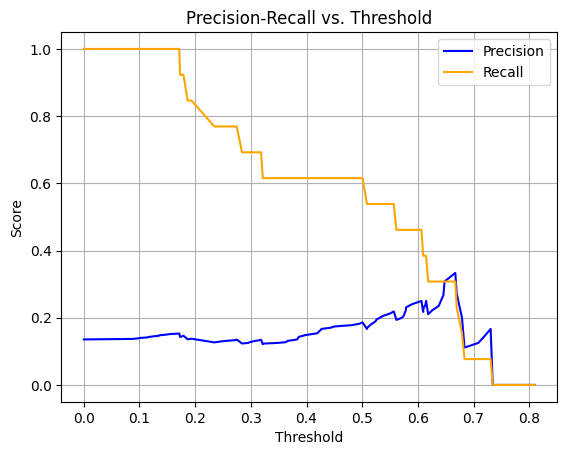

In [ ]:
# Step 6: Threshold Tuning
import numpy as np

# Get predicted probabilities instead of hard predictions
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Define custom thresholds and evaluate performance
thresholds = np.arange(0.1, 1.0, 0.1)
for threshold in thresholds:
    y_pred_custom = (y_prob >= threshold).astype(int)
    print(f"Threshold: {threshold:.1f}")
    print(classification_report(y_test, y_pred_custom))
    print(confusion_matrix(y_test, y_pred_custom))
    print("-" * 50)

# Add Precision-Recall vs. Threshold Plot
# Generate precision and recall values for different thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# Plot Precision and Recall against thresholds
plt.plot(thresholds, precisions[:-1], label="Precision", color="blue")
plt.plot(thresholds, recalls[:-1], label="Recall", color="orange")
plt.title("Precision-Recall vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

Final Model Accuracy with Threshold 0.6: 0.74

Final Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.84        83
           1       0.25      0.46      0.32        13

    accuracy                           0.74        96
   macro avg       0.58      0.62      0.58        96
weighted avg       0.81      0.74      0.77        96


Final Confusion Matrix:
[[65 18]
 [ 7  6]]


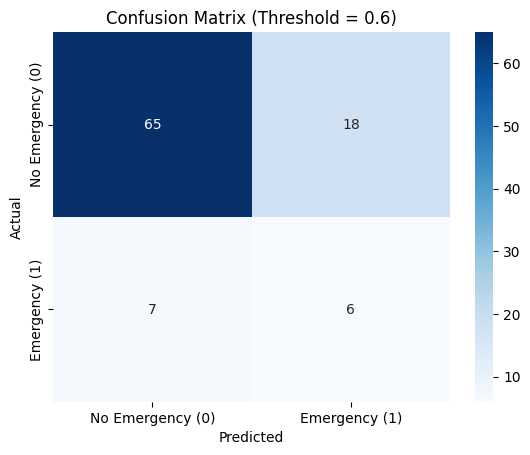

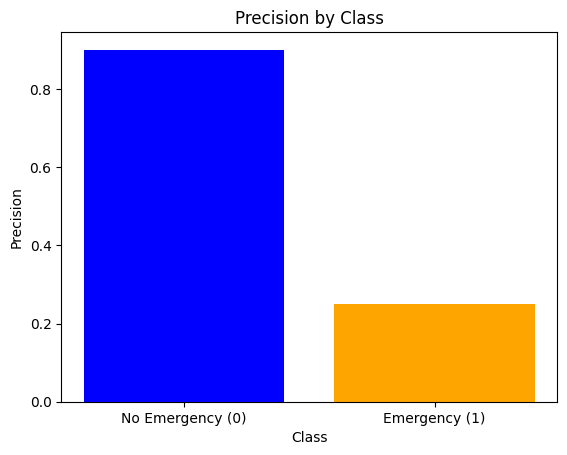

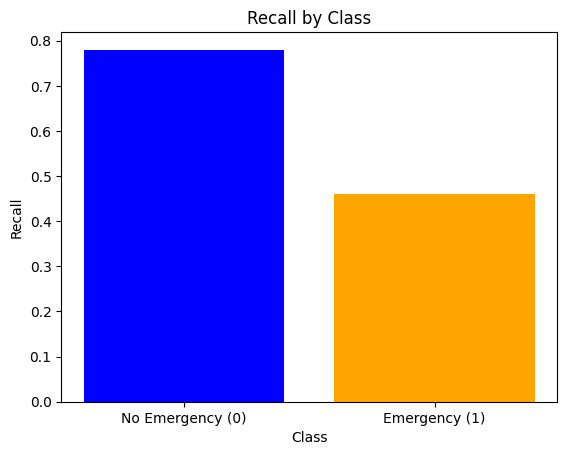

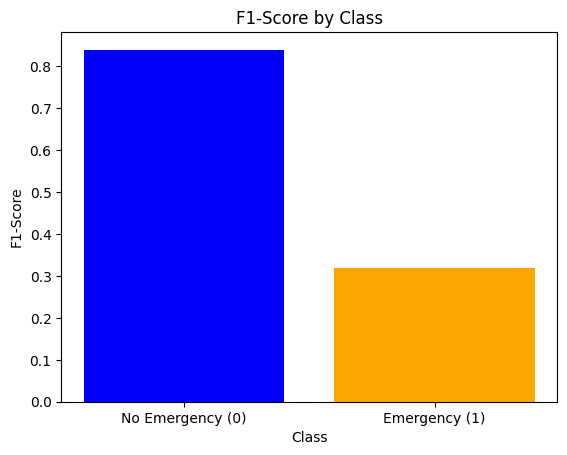

In [ ]:
# Use the tuned threshold of 0.6 for final predictions
final_threshold = 0.6
y_pred_final = (y_prob >= final_threshold).astype(int)

# Evaluate the model with the selected threshold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(f"Final Model Accuracy with Threshold {final_threshold}: {accuracy_score(y_test, y_pred_final):.2f}")

print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred_final))

print("\nFinal Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

# Add Confusion Matrix Heatmap
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_final)

# Plot the heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Emergency (0)', 'Emergency (1)'], yticklabels=['No Emergency (0)', 'Emergency (1)'])
plt.title("Confusion Matrix (Threshold = 0.6)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("""

""")

# Add Performance Metrics Bar Chart
# Example performance metrics
metrics = {
    'Precision': [0.90, 0.25],
    'Recall': [0.78, 0.46],
    'F1-Score': [0.84, 0.32]
}
classes = ['No Emergency (0)', 'Emergency (1)']

# Create a bar chart for each metric
for metric_name, values in metrics.items():
    plt.bar(classes, values, color=['blue', 'orange'])
    plt.title(f"{metric_name} by Class")
    plt.xlabel("Class")
    plt.ylabel(metric_name)
    print("""

    """)
    plt.show()